Example notebook showing the use of SNCatalog. To run this notebook, we will need:
- The LSST simulations stack setup (sims_catUtils) 
- A version of SNCosmo. You may use the one in the stack by setup sncosmo
- Have the OpSim database enigma_1189_sqlite.db on disk. This is used to obtain samples of points (in time) with given fivesigmadepth. The second code block of the **Setup** section is used to do this. Please change the path to point to your OpSim database.

For this example to work without connecting to a server, we will create a database of fake galaxies on disk. These galaxies should be thought of as positions only, and do not have specific physical properties set to reasonable values. Neither will the frequency of supernovae in galaxies be set to reasonable values to enable us to sample some light curves quickly. 

We only do this at the location of DDF with FieldID 290. Our steps are : 

1. **Setup** Some setup functionality
2. **Fake Galaxy Catalog** : Create a Fake galaxy database for galaxies at locations around the field of view we chose. This will be done using ObsMetaData
3. **Instance Catalogs of SNIa** : We create Instance Catalogs of SNIa hosted on the galaxies in the database created in the previous step. These instance Catalogs include expected values of measured flux/magnitude and their uncertainties. The uncertainties are based on the observing conditions which are read off from Observation MetaData. The ObservationMetaData are based on OpSim Observations. Here we choose to use a Deep Drilling Field (FieldID 290) on certain dates where we know there are observations. 
4. **Rebuilding Light Curves**: For each Instance Catalog, we write the catalog to disk. We then read in all of the catalogs, and rebuild the light curve by grouping observations corresponding to a SNIa identified by a unique ID.

##  Setup

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sqlite3

In [2]:
opsimPath = os.path.join('/Users/rbiswas/data/LSST/OpSimData')
opsimDB = os.path.join(opsimPath,'enigma_1189_sqlite.db')

In [3]:
from lsst.sims.catUtils.mixins import CosmologyMixin
from lsst.sims.utils import ObservationMetaData
from lsst.sims.catUtils.utils import ObservationMetaDataGenerator
from lsst.sims.catalogs.generation.db import CatalogDBObject
from lsst.sims.catalogs.measures.instance import InstanceCatalog
import eups

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want

In [4]:
from lsst.sims.catUtils.mixins import SNIaCatalog
from lsst.sims.catUtils.supernovae import SNObject

In [5]:
def cleanDB(dbname, verbose=True):
    '''
    Deletes the database dbname from the disk.
    Parameters
    ----------
    dbname: string, mandatory
        name (abs path) of the database to be deleted
    verbose: Bool, optional, defaults to True

    '''

    if os.path.exists(dbname):
        if verbose:
            print "deleting database ", dbname
        os.unlink(dbname)
    else:
        if verbose:
            print 'database ', dbname, ' does not exist'
            

In [6]:
from lsst.sims.utils import spatiallySample_obsmetadata as sample_obsmetadata

In [7]:
def _createFakeGalaxyDB(dbname, ObsMetaData, size=10000, seed=1):
    '''
    Create a local sqlite galaxy database having filename dbname with variables
    id, raJ2000, decJ2000 and redshift, having number of rows =size, and having
    overlap with ObsMetaData.
    '''
    cleanDB(dbname)
    conn = sqlite3.connect(dbname)
    curs = conn.cursor()
    curs.execute('CREATE TABLE if not exists gals (id INT, raJ2000 FLOAT,\
                  decJ2000 FLOAT, redshift FLOAT)')

    np.random.seed(seed)
    samps = sample_obsmetadata(ObsMetaData, size=size)

    for count in range(size):
        id = 1000000 + count

        # Main Database should have values in degrees
        ra = samps[0][count]
        dec = samps[1][count]
        redshift = np.random.uniform()
        row = tuple([id, ra, dec, redshift])
        exec_str = insertfromdata(tablename='gals', records=row,
                                     multiple=False)
        curs.execute(exec_str, row)

    conn.commit()
    conn.close()
    return samps

In [8]:
def insertfromdata(tablename, records, multiple=True):
    """
    construct string to insert multiple records into sqlite3 database
    args:
        tablename: str, mandatory
            Name of table in the database.
        records: set of records
        multiple:
    returns:
    """
    if multiple:
        lst = records[0]
    else:
        lst = records
    s = 'INSERT INTO ' + str(tablename) + ' VALUES '
    s += "( " + ", ".join(["?"]*len(lst)) + ")"
    return s

In [9]:
class myGalaxyCatalog(CatalogDBObject):
    '''
    Create a like CatalogDBObject connecting to a local sqlite database
    '''

    objid = 'mytestgals'
    tableid = 'gals'
    idColKey = 'id'
    objectTypeId = 0
    appendint = 10000
    database = 'testdata/galcat.db'
    # dbAddress = './testData/galcat.db'
    raColName = 'raJ2000'
    decColName = 'decJ2000'
    driver = 'sqlite'

    # columns required to convert the ra, dec values in degrees
    # to radians again
    columns = [('id', 'id', int),
               ('raJ2000','raJ2000 * PI()/ 180. '),
               ('decJ2000','decJ2000 * PI()/ 180.'),
               ('redshift', 'redshift')]

Throughputs: We will need these to evaluate fluxes

In [10]:
import pandas as pd
from astropy.table import Table
import sncosmo

In [11]:
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

In [12]:
from lsst.sims.photUtils import Bandpass
from lsst.sims.photUtils import BandpassDict

bandpassnames = ['u', 'g', 'r', 'i', 'z', 'y']
LSST_BandPass = BandpassDict.loadTotalBandpassesFromFiles()

## Fake Galaxy Catalog DataBase

This ObservationMetaData Instance in instantiated at the location of the DDF field of interest. As the SNe inherit from the galaxy catalog, these galaxies must be in the region of interest. The mjd parameter does not play a role as galaxies are static objects. Similarly the bandpassName atribute has no effect.

The positions of the galaxies are randomly selected within the region specified by the ObservationMetaData. This is done through the `lsst.sims.utils.sample_obsmetadata` function which samples the spatial region of an OnsMetaData instance. We will choose our Observation region to be around RA of 349.3 degrees and Dec of -63.3 degrees. These coordinates are called centralRA, centralDec respectively

In [13]:
# These are in degrees
centralRA = 349.3
centralDec = -63.3
galaxyPatchSize = np.degrees(0.25)

In [14]:
obsMetaDataforCat = ObservationMetaData(boundType='circle',
                                        boundLength=galaxyPatchSize,
                                        pointingRA=centralRA,
                                        pointingDec=centralDec,
                                        bandpassName=['r'],
                                        mjd=49350.)

Let us check a few properties of this instance of ObservationMetaData

In [15]:
sample_obsmetadata(obsMetaDataforCat, size=1)

(array([ 346.92285554]), array([-66.14652442]))

In [16]:
obsMetaDataforCat.boundLength

14.323944878270581

In [17]:
obsMetaDataforCat._boundLength

0.25

Create the directory where we will store the galaxy database and the SNIa catalogs. Create the values of positions for the Fake galaxies and store in the the database `testSNData/galcat.db`. This will clobber previous files of the same name.

In [18]:
if not os.path.exists('testSNData'):
    os.makedirs('testSNData')
testdbName = 'testSNData/galcat.db'
vals = _createFakeGalaxyDB(dbname=testdbName,
                           ObsMetaData=obsMetaDataforCat,
                           size=1000000,
                           seed=1)

deleting database  testSNData/galcat.db


We cat now visualize the location of the galaxies (in blue) and the centralRA, and centralDec in red

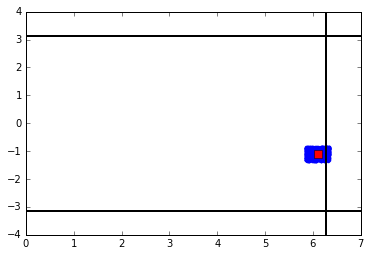

In [19]:
plt.plot(np.radians(vals[0][:1000]), np.radians(vals[1][:1000]), '.')
plt.axvline(2. * np.pi, color='k', lw=2.)
plt.axvline(0., color='k', lw=2.)
plt.axhline(np.pi, color='k', lw=2.)
plt.axhline(-np.pi, color='k', lw=2.)
plt.plot([np.radians(centralRA)], [np.radians(centralDec)], 'rs', markersize=8)

In [20]:
galDB = myGalaxyCatalog(database=testdbName)

In [21]:
class galCopy(InstanceCatalog):
    column_outputs = ['id', 'raJ2000', 'decJ2000', 'redshift']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e'}

In [22]:
galphot = galCopy(db_obj=galDB, obs_metadata=obsMetaDataforCat)


In [23]:
galphot.write_catalog('gals.dat')

In [24]:
!wc -l gals.dat

  958820 gals.dat


In [25]:
!head gals.dat

#id, raJ2000, decJ2000, redshift
1000000, 6.054946e+00, -9.029905e-01, 0.0376
1000001, 6.206597e+00, -1.139951e+00, 0.7608
1000002, 5.846492e+00, -1.072297e+00, 0.9737
1000003, 5.997601e+00, -9.194755e-01, 0.1566
1000004, 5.919813e+00, -9.140243e-01, 0.8494
1000005, 5.892604e+00, -9.430854e-01, 0.5251
1000006, 5.939565e+00, -1.270477e+00, 0.1618
1000007, 6.019215e+00, -8.845809e-01, 0.3991
1000008, 6.044819e+00, -9.364637e-01, 0.7685


## Instance Catalogs of SNIa


We would like to create a number of supernova instance catalogs and then build the light curves from the catalogs. To do this correctly, we would like to use the observation_metadata associated with a number of conscutive OpSIM pointings.

In [26]:
# In order to use the OpSim which is part of sims_data, uncomment the following two lines to override the 
# Opsim database setup in the **setup** section

#opsimPath = os.path.join(eups.productDir('sims_data'),'OpSimData')
#opsimDB = os.path.join(opsimPath,'opsimblitz1_1133_sqlite.db')
print opsimDB


# from Tuscon AHM notebook from Scott
# This OPSIM DB is provided in sims_data. This creates a list of opsim pointings
# that I have checked. This is a tuned notebook
generator = ObservationMetaDataGenerator(driver='sqlite', database=opsimDB) #database = opsimPath, driver='sqlite')
obsMetaDataResults = generator.getObservationMetaData(limit=1000,
                                                      fieldRA=(centralRA-2.0, centralRA +2.0), 
                                                      fieldDec=(centralDec-2.0, centralDec+2.0),
                                                      expMJD=(49500., 49590.),
                                                      boundLength=0.015,
                                                      boundType='circle')
                                            

/Users/rbiswas/data/LSST/OpSimData/enigma_1189_sqlite.db


In [27]:
# A short block to check what you should be seeing
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + opsimDB)

dff = pd.read_sql_query('SELECT * FROM SUMMARY WHERE FIELDID is 290 and expMJD < 49590 and expMJD > 49490', engine)

In [28]:
dff.head()

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,114367,1189,363,290,6.097944,-1.10516,y,11960383,49491.430360,138,...,0.000000,95.330805,0.414974,0,0,0.055193,4.672322,21.637128,6.080937,-1.098547
1,114377,1189,363,290,6.097944,-1.10516,y,11960769,49491.434829,138,...,0.000000,94.872840,0.482168,0,0,0.055193,4.646860,21.551827,6.080937,-1.098547
2,121892,1189,363,290,6.097944,-1.10516,z,12808885,49501.250988,148,...,580.725466,131.390206,0.504399,0,0,0.055193,4.863491,22.260523,6.042673,-1.095241
3,130397,1189,363,290,6.097944,-1.10516,r,14358187,49519.182728,166,...,44.945417,139.174707,0.566910,0,0,0.055025,4.833909,23.874776,6.080937,-1.091934
4,131614,1189,363,290,6.097944,-1.10516,y,14535396,49521.233761,168,...,142.789597,118.370643,0.661373,0,0,0.140105,6.262073,21.270300,6.097944,-1.091934


In [29]:
# How many pointings do we have? 
print (len(obsMetaDataResults))

837


We can check the frequency of occurances of observations on the days selected

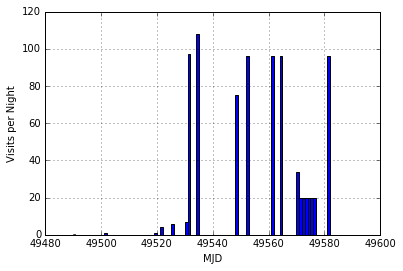

In [30]:
_ = plt.hist(map(lambda x: x.mjd.TAI, obsMetaDataResults ), bins=np.arange(49490, 49590,1))
plt.xlabel('MJD')
plt.ylabel('Visits per Night')
plt.grid(True)

And the spatial location of all the galaxies

In [31]:
def coords(x):
    return np.radians(x.pointingRA), np.radians(x.pointingDec)  

In [32]:
v = zip(*map(coords, obsMetaDataResults))

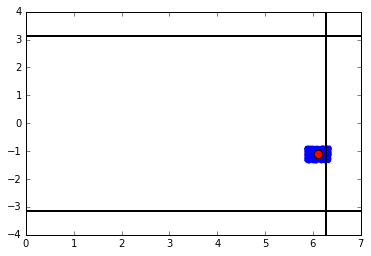

In [33]:
plt.plot(v[0], v[1], 'ko', markersize=4)
plt.plot(np.radians(vals[0][:1000]),np.radians(vals[1][:1000]), '.')
plt.axvline(2. * np.pi, color='k', lw=2.)
plt.axvline(0., color='k', lw=2.)
plt.axhline(np.pi, color='k', lw=2.)
plt.axhline(-np.pi, color='k', lw=2.)
plt.plot(v[0], v[1], 'ro', markersize=8)

In [34]:
if not os.path.exists('testSNData/NewLightCurves'): 
    os.makedirs('testSNdata/NewLightCurves')

In [35]:
column_outputs=['flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_y',
                'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y']

In [36]:
# Slow Step (takes about 50 seconds before anything starts getting printed (first 100), about 9 times that time to complete)
def ourWriteCatalog(obsMetaDataResults):
    fnameList = []
    for obsind, obsMetaData in enumerate(obsMetaDataResults):
        if obsind % 100 == 0:
            print(obsind) 
        #print obsMetaData.mjd
        newcatalog = SNIaCatalog(db_obj=galDB, 
                                 obs_metadata=obsMetaData, 
                                 column_outputs=['t0', 'cosmologicalDistanceModulus', 'mwebv','time', 'band', 'flux', 'flux_err', 'mag', 'mag_err'])
        #print ('Instantiated newcatalog')
        newcatalog.midSurveyTime=49540
        newcatalog.snFrequency =100.
        newcatalog.suppressDimSN = True
        fname =  'testSNData/NewLightCurves/SNCatalog_' + "{0:d}".format(obsind)
        #print ('printing name' , fname)
        newcatalog.write_catalog(fname)
        fnameList.append(fname)
        #print (obsMetaData.mjd.TAI)
    return fnameList

In [37]:
fnamelist = ourWriteCatalog(obsMetaDataResults)

0
100
200
300
400
500
600
700
800


In [38]:
dfs = []
_ = map(lambda x: dfs.append(pd.read_csv(x, index_col=None, sep=', ')), fnamelist)
all_lcs = pd.concat(dfs)
all_lcs.rename(columns={'#snid': 'snid'}, inplace=True)
lcs = all_lcs.groupby('snid')

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [39]:
def SNCosmoModel(lc):
    f = np.unique(np.asarray(lc[['z', 'c', 'x1', 't0', 'x0','snra', 'sndec']]))
    f = np.asarray(lc[['z', 'c', 'x1', 't0', 'x0', 'snra', 'sndec']])[0]
    #SNO = SNObject(ra=f['snra'][0], dec=f['sndec'][0])
    SNO = SNObject(ra=f[-2], dec=f[-1])
    SNO.set(z=f[0], c=f[1], x1=f[2], t0=f[3], x0=f[4])
    sn = SNO.equivalentSNCosmoModel()
    return sn,  SNO

1801075
1705668
1385591


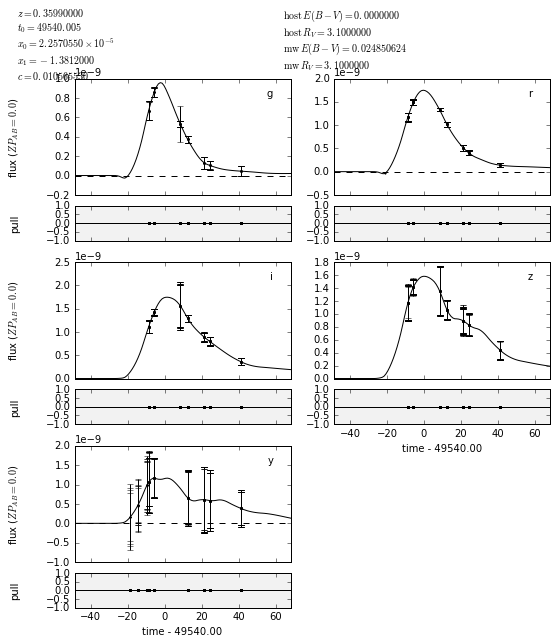

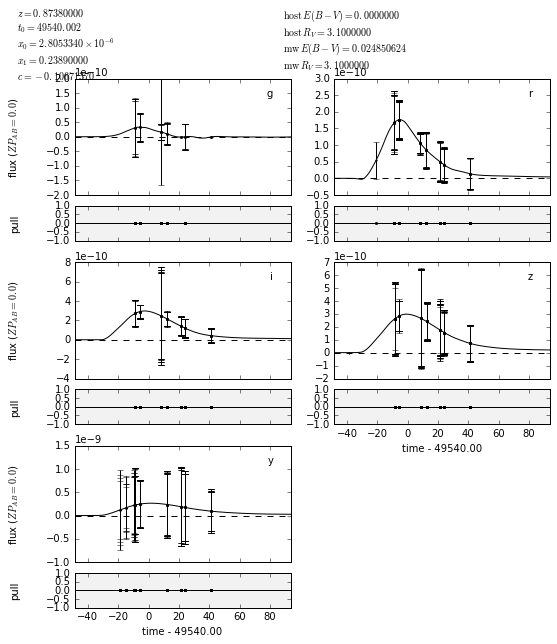

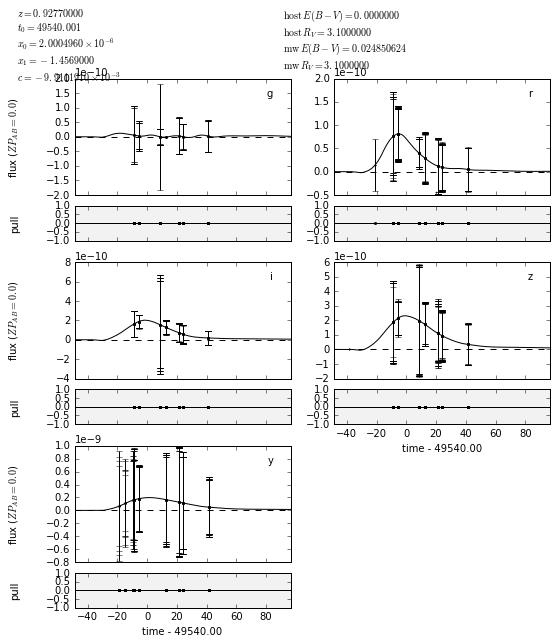

In [40]:
figs = []
for snid in lcs.groups.keys():
    print(snid)
    df = lcs.get_group(snid).query("band!='u'")
    strarr = df.to_records()
    data = Table(strarr)
    data['zp'] = 0.
    data['zpsys'] = 'ab'
    data.rename_column('flux_err', 'fluxerr')
    data['fluxerr'] = data['fluxerr'].astype('float')
    data['mag_err'] = data['mag_err'].astype('float')
    
    sn = SNCosmoModel(df)
    fig = sncosmo.plot_lc(data, zp=0., color='k', model=sn[0])#, model=sn, color='k')
    fig.set_label(str(snid))
    figs.append(fig)

In [41]:
figs[0].savefig('SN_lc_zpt4.pdf')
figs[1].savefig('SN_lc_morepts.pdf')

## Demonstrate Repeatability

This means that from the values in data of snid (which by
construction is the hostid (and the seed), we should be able to find the parameters of the supernova, and match it to the catalog values. 


In [42]:
from lsst.sims.catUtils.supernovae import SNUniverse

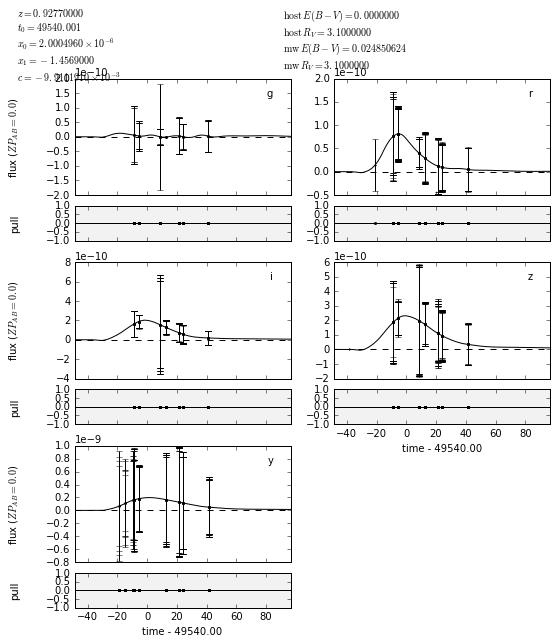

In [43]:
# Look at Parameters for comparison
figs[-1]

In [44]:
lcs.groups.keys()[-1]

1385591

In [45]:
cat = SNIaCatalog(db_obj=galDB, 
                  obs_metadata=obsMetaDataResults[0])

In [46]:
# Set the universe to be the same one
cat.midSurveyTime=49540.
cat.snFrequency =100.

In [47]:
cat.drawSNParams(hostid=1944733, hostmu=43.2148)

[0.058116382111016454,
 0.42918020256495887,
 2.8915010927385478e-06,
 49539.999890533014]

Since the values of the SN parameters in the figure and the parameters drawn using this function match, repeatability works